In [177]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from pprint import pprint
nltk.download('punkt')
from nltk.draw.dispersion import dispersion_plot

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\beelk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
# Converting to pandas dataframe
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Easy check in and staff mem...
1,✅ Trip Verified | Being a silver flyer and bo...
2,Not Verified | I find BA incredibly tacky and...
3,✅ Trip Verified | Flew ATL to LHR 8th Jan 202...
4,Not Verified | Great thing about British Airw...


In [5]:
# exporrting to a csv format
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [7]:
# As we can see the text data is messy. We need to remove the tick/cross sign and split the verification status from the actual review
df['reviews']

0      ✅ Trip Verified |  Easy check in and staff mem...
1      ✅ Trip Verified |  Being a silver flyer and bo...
2      Not Verified |  I find BA incredibly tacky and...
3      ✅ Trip Verified |  Flew ATL to LHR 8th Jan 202...
4      Not Verified |  Great thing about British Airw...
                             ...                        
995    ✅ Trip Verified | BA used to be a byword for q...
996    ✅ Trip Verified | Premium economy worse than m...
997    ✅ Trip Verified | Flew Belfast to London with ...
998    ✅ Trip Verified | Naples to Gatwick. The onlin...
999    ✅ Trip Verified | I have been flying with BA f...
Name: reviews, Length: 1000, dtype: object

In [8]:
# Splitting
df[['Verification status','Review']] = df.reviews.str.split('|',expand = True)

In [11]:
# Dropping the orignal 'reviews' columns as it is unnecessary
df = df.drop(columns = ['reviews'])

In [13]:
# We still have to get rid of the tick sign
df.head(5)

,Verification status,Review
0,✅ Trip Verified,Easy check in and staff member was polite an...
1,✅ Trip Verified,Being a silver flyer and booking a flight th...
2,Not Verified,I find BA incredibly tacky and constantly lo...
3,✅ Trip Verified,Flew ATL to LHR 8th Jan 2023. Was unlucky en...
4,Not Verified,Great thing about British Airways A380 is th...


In [20]:
df['Verification status'] = df['Verification status'].str.replace(r'✅', '')
df['Verification status'] = df['Verification status'].str.replace(r'❎', '')
df['Verification status'] = df['Verification status'].str.strip() # removing the spaces

In [36]:
df.head(5)

,Verification status,Review
0,Trip Verified,Easy check in and staff member was polite an...
1,Trip Verified,Being a silver flyer and booking a flight th...
2,Not Verified,I find BA incredibly tacky and constantly lo...
3,Trip Verified,Flew ATL to LHR 8th Jan 2023. Was unlucky en...
4,Not Verified,Great thing about British Airways A380 is th...


In [37]:
df['Verification status'].unique()

array(['Trip Verified', 'Not Verified'], dtype=object)

In [38]:
df.to_csv("BA_reviews_cleaned.csv")

In [109]:
sentiment_score = []
def apply_textblob():
    for i in range(len(df['Review'])):
        blob = TextBlob(df['Review'][i])
        sentiment = blob.sentiment.polarity # returns a core of -1 to 1. Closer to -1 means a negative reivew and closer to 1 means the opposite.
        sentiment_score.append(sentiment)
    sentiment_score_series = pd.Series(sentiment_score)
    df['sentiment'] = sentiment_score_series.values

In [110]:
apply_textblob()

In [111]:
df.head(5)

,Verification status,Review,sentiment,sentiment_score
0,Trip Verified,Easy check in and staff member was polite an...,0.353283,0
1,Trip Verified,Being a silver flyer and booking a flight th...,0.210714,0
2,Not Verified,I find BA incredibly tacky and constantly lo...,0.104487,0
3,Trip Verified,Flew ATL to LHR 8th Jan 2023. Was unlucky en...,-0.147953,0
4,Not Verified,Great thing about British Airways A380 is th...,0.075123,0


In [112]:
# Binning the sentiment socres. If it's less than 0 (closer to -1) we label it as 0 and vice versa for positive reviews.
def binning(val):
    if val > 0:
        return 1
    else:
        return 0

In [113]:
df['sentiment_score'] = df['sentiment'].apply(binning)

In [114]:
df.head(5)

,Verification status,Review,sentiment,sentiment_score
0,Trip Verified,Easy check in and staff member was polite an...,0.353283,1
1,Trip Verified,Being a silver flyer and booking a flight th...,0.210714,1
2,Not Verified,I find BA incredibly tacky and constantly lo...,0.104487,1
3,Trip Verified,Flew ATL to LHR 8th Jan 2023. Was unlucky en...,-0.147953,0
4,Not Verified,Great thing about British Airways A380 is th...,0.075123,1


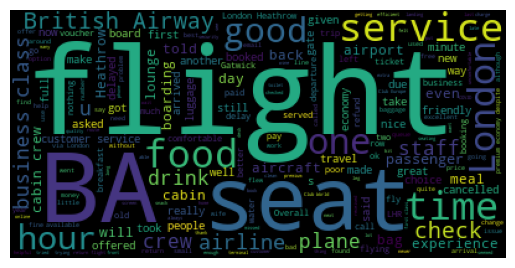

In [129]:
wordcloud = WordCloud().generate(' '.join(df['Review']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [119]:
df['sentiment_score'].value_counts()

1    667
0    333
Name: sentiment_score, dtype: int64

As we can see, 66.7% of the reviews are positive which is a good thing. Let's analyze the negative reviews a bit more.

In [122]:
df2 = df

In [128]:
negative_reviews = df2[df2['sentiment_score'] == 0]

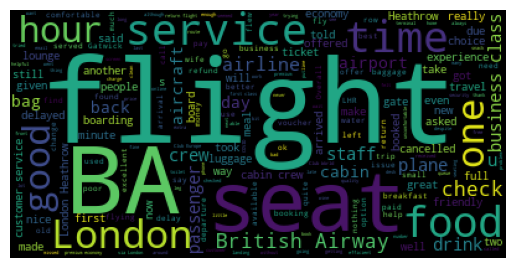

In [130]:
wordcloud = WordCloud().generate(' '.join(df2['Review']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [133]:
negative_text = (' '.join(df2['Review']))

In [140]:
negative_text

'  Easy check in and staff member was polite and helpful and made a specific point of acknowledging our loyalty to BA. Security at London was fast. Galleries North was fine and showers were good. Organised flight boarding. Plane was fine with good crew and new club world product. My wife had a damaged storage area but otherwise ok. After take off there was a good drinks and food service which was well run. Slept well on time arrival. We both found the new seat design harder to sleep in.   Being a silver flyer and booking a flight through BA to Dublin you would have thought I could use the lounge even though BA used Air Lingus for the flight. Travelled recently there with the same situation and was allowed in by a kind Gentleman at the desk even though he said I had to be Gold ? He was really accommodating and it wasn’t a big deal. But the two ladies on the desk were like no. No empathy there at all-saying the other guy shouldn’t have let me and they will have a word with him ? Come on 

In [141]:
type(negative_text)

str

In [169]:
def custom_tokenize(text):
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return word_tokenize(text)
tokens = custom_tokenize(negative_text)

In [172]:
text = nltk.Text(tokens)

In [175]:
text.concordance('horrible')

Displaying 20 of 20 matches:
Extra wait in Milan then . Food is horrible . Check in was a shambles at BWI ,
mped and the seats in economy were horrible . I was seated in an aisle seat ( 
ping at people and just had a real horrible way about her . On the flight from
 space . No pillows , no blanket , horrible inflight service , staff were hara
r to our flight . Food service was horrible ( they served food with lots of ch
on , service that needs training , horrible food and no internet in business c
returning no empty seat and it was horrible . I 'm only 5 ' 5 and female but c
torage room and working space is . Horrible low cost service for a flag carrie
to plane was disorganized bedlam . Horrible excuse for an airline . Buenos Air
 my first time but the legroom was horrible . The IFE completely unfunctional 
to file a claim . Your website was horrible to use to file this claim and I ha
he food on both legs of the flight horrible . Phoenix to Amsterdam via London 
enough . Their customer

In [176]:
text.concordance('bad')

Displaying 25 of 95 matches:
LHR flight was cancelled ( due to the bad weather in Vancouver ) . We did not r
near before the conditions became too bad . If they had taken advice they would
flew back economy , which was n't too bad either . The flight attendants were f
 screen . The seat itself was n't too bad but I felt squished and locked in . O
I bolted again into the plane feeling bad that I did not personally thank her f
ful experience for any passenger , is bad enough . For someone who is not mobil
. British Airways customer service is bad and needs to be worked on . Till toda
 service of British Airways is really bad . You ca n't reach any call centre ag
r flights were alright but after such bad customer service we will never fly BA
. Every time I fly with BA , I have a bad experience and I promise I will never
00 more than originally booked due to bad rep advice and multiple calls to the 
with good results . This was a really bad experience and I will avoid using BA 
was good fo

In [179]:
text.similar('poor')

good nice great bad comfortable old that disappointing friendly
pleasant disappointed and a the uncomfortable tasty small available
quick dreadful


In [182]:
text.concordance('disappointing')

Displaying 25 of 33 matches:
is terrible . This flight was so disappointing . Other than one great member of
nctional entertainment equipment disappointing . Having to step over the reclin
true as Air France manage it ) . Disappointing meal , wine served so late after
em but mediocre film selection . Disappointing breakfast . Overall : 3 / 10 . F
 you pay the premium price for ? Disappointing again especially on business . T
a bacon roll and coffee served . Disappointing that the wait for cases at Heath
ard amenities and services quite disappointing . Seat was reasonably spacious b
 the flight . Overall , a fairly disappointing experience with BA . LHR to SFO 
 good , food ok , wines a little disappointing . Overall a decent flight . Flig
f service on the inbound leg was disappointing . Safety briefing was missed on 
 Dinner was good , breakfast was disappointing with little choice . The LHR to 
ts , whereas the return trip was disappointing . Check in was fine , apart from
y requested

In [183]:
text.concordance('uncomfortable')

Displaying 25 of 63 matches:
 seat as my Wife and I were very uncomfortable . The leg room in general is poo
we suffered the most appallingly uncomfortable flights with no room ( eight sea
ified . I was rebooked on a very uncomfortable trip . Inbound flight delayed 1 
 this afterwards ? Seat was very uncomfortable indeed on this aircraft so got l
 seat and floor . The seats were uncomfortable . Food for business class passen
xcept the shoulder strap is very uncomfortable . Entertainment great . Wifi was
 for years , what a shock ! Hard uncomfortable seats , small aged tv screens wi
ck again . Boarding was slow and uncomfortable on account of the lack air-con a
upied and the seats were just as uncomfortable when lying flat . Storage was a 
nd gate . Crew good , seats very uncomfortable . After 1h queuing at the check-
craft . Very cramped seating and uncomfortable . The armrests between seats are
 service . Seating was extremely uncomfortable , 29 inch pitch and 17 inch wide
 of the han

In [184]:
text.concordance('dreadful')

Displaying 19 of 19 matches:
 of this has been nothing short of dreadful , and if given the option , I will
e I was already struggling through dreadful driving conditions to get to the a
nsation for what would have been a dreadful experience for any passenger , is 
ever fly with them again . Another dreadful mediocre experience with BA to Mal
My wife 's smoked salmon bagel was dreadful . As usual when BA is good , it 's
e illusion of style . The food was dreadful . The in flight service was unsoph
 of cost cutting and the result is dreadful . Outstanding ! From the warm , sm
duct has held up so well amid this dreadful time , and I 'm looking forward to
nny pinching by BA in club class . Dreadful - not for us again . Flew Club Eur
seats are not so comfortable . Not dreadful but something for BA to think abou
ns about our intentions . It was a dreadful way to end our honeymoon and left 
d Unforgettable. ’ The service was dreadful , but the journey was definitely u
7-400 's , but they per

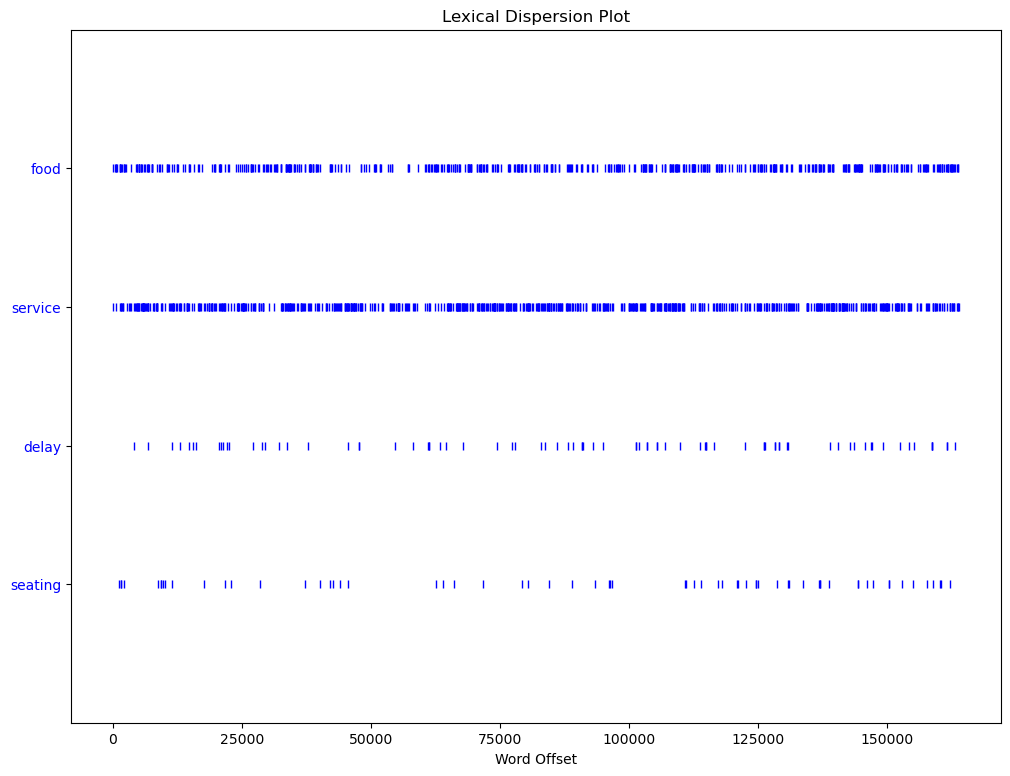

In [185]:
plt.figure(figsize=(12, 9))
targets=['food','service','delay','seating']
dispersion_plot(text, targets, ignore_case=True, title='Lexical Dispersion Plot')

As we can see some the reasons for poor reviews are uncomfortable seating, bland food, delays and customer service. Detailed explanation will be presented in the slide. 